# Using a GAN to generate images

In [1]:
import logging
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets
from torchvision.transforms import v2


logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s: %(message)s",
)

logger = logging.getLogger(__name__)

In [2]:
def get_torch_device() -> str:
    return (
        "cuda" if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available()
        else "cpu"
    )


def set_torch_seed(seed: int) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


def get_dataloader(batch_size: int, train: bool, resize_to: int):
    mnist_dataset = datasets.FashionMNIST(
        root="data",
        train=train,
        download=True,
        transform=v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Resize((resize_to, resize_to))
        ]),
    )

    return torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size)

In [3]:
# Based on networks at https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On/blob/master/Chapter03/03_atari_gan.py

class DiscriminatorNetwork(torch.nn.Module):
    """
    The Discriminator takes an image as an input and outputs
    a single value, a prediction on whether it is a real or
    fake image.
    """
    def __init__(self, input_shape, discr_filters):
        super().__init__()
        self.conv_pipe = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=input_shape[0],
                out_channels=discr_filters,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            torch.nn.ReLU(),
            torch.nn.Conv2d(
                in_channels=discr_filters,
                out_channels=discr_filters * 2,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            torch.nn.BatchNorm2d(discr_filters * 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(
                in_channels=discr_filters * 2,
                out_channels=discr_filters * 4,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            torch.nn.BatchNorm2d(discr_filters * 4),
            torch.nn.ReLU(),
            torch.nn.Conv2d(
                in_channels=discr_filters * 4,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0,
            ),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_pipe(x)
        return x.view(-1, 1).squeeze(dim=1)


class GeneratorNetwork(torch.nn.Module):
    """
    The Generator takes a latent vector of inputs, and outputs
    an image.
    """
    def __init__(self, output_shape, latent_vector_size, gener_filters):
        super().__init__()
        self.pipe = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels=latent_vector_size,
                out_channels=gener_filters * 4,
                kernel_size=4,
                stride=1,
                padding=0,
            ),
            torch.nn.BatchNorm2d(gener_filters * 4),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(
                in_channels=gener_filters * 4,
                out_channels=gener_filters * 2,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            torch.nn.BatchNorm2d(gener_filters * 2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(
                in_channels=gener_filters * 2,
                out_channels=gener_filters,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            torch.nn.BatchNorm2d(gener_filters),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(
                in_channels=gener_filters,
                out_channels=output_shape[0],
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            torch.nn.Tanh()
        )

    def forward(self, x):
        return self.pipe(x)


def _test_discriminator() -> None:
    input_size = 32
    batch_size = 10
    network = DiscriminatorNetwork(input_shape=(1, input_size, input_size), discr_filters=8)
    nn_input = torch.ones((batch_size, 1, input_size, input_size))
    result = network(nn_input)
    assert result.shape == (batch_size, )


def _test_generator() -> None:
    batch_size = 10
    network = GeneratorNetwork(output_shape=(1, -1, -1), latent_vector_size=13, gener_filters=32)
    nn_input = torch.ones((batch_size, 13, 1, 1))
    result = network(nn_input)
    assert result.shape == (batch_size, 1, 32, 32)


_test_discriminator()
_test_generator()

In [4]:
def show_nine(images):
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for i, ax in enumerate(axes.flatten()):
        image = images[i, :].cpu().detach().numpy()
        ax.imshow(image.squeeze(0), cmap="gray")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()


def show_examples(generator, latent_vector_size):
    torch_device = next(generator.parameters()).device
    gen_input = torch.randn(9, latent_vector_size, 1, 1, device=torch_device)
    gen_output = generator(gen_input)
    show_nine(gen_output)

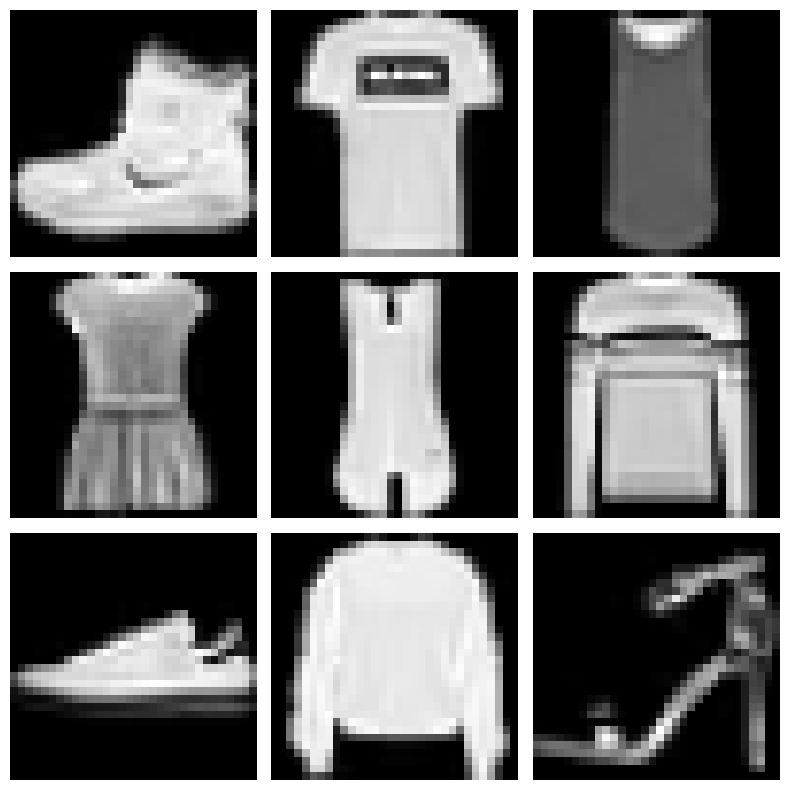

In [5]:
example_dataloader = get_dataloader(9, True, 32)
examples = next(iter(example_dataloader))[0]
examples.shape
show_nine(examples)

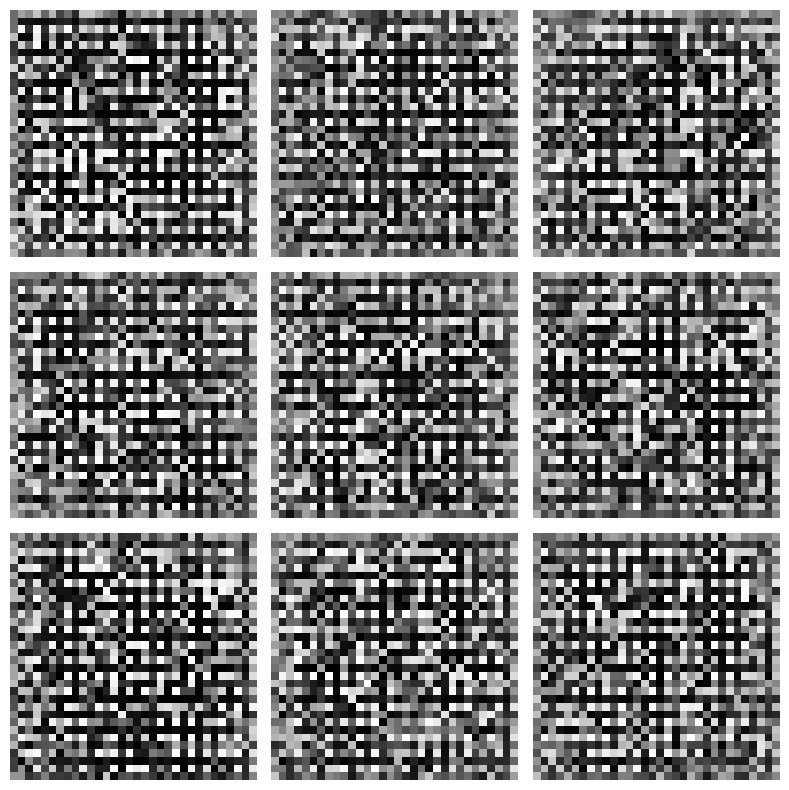

In [6]:
batch_size = 64
epochs = 50
initial_learning_rate = 5e-4
latent_vector_size = 100
input_size = 32

reports_per_epoch = 5

set_torch_seed(123)

dataloader = get_dataloader(batch_size, True, input_size)
shape = next(iter(dataloader))[0].shape[1:]

torch_device = get_torch_device()
discriminator = DiscriminatorNetwork(input_shape=shape, discr_filters=input_size).to(torch_device)
dis_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=initial_learning_rate, betas=(0.5, 0.999))
dis_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(dis_optimizer, T_max=epochs, eta_min=1e-5)

generator = GeneratorNetwork(output_shape=shape, latent_vector_size=latent_vector_size, gener_filters=input_size).to(torch_device)
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=initial_learning_rate, betas=(0.5, 0.999))
gen_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(gen_optimizer, T_max=epochs, eta_min=1e-5)

show_examples(generator, latent_vector_size)

In [7]:
loss_fn = torch.nn.BCELoss()

gen_losses = []
dis_losses = []

discriminator.train()
generator.train()

report_interval = len(dataloader) // reports_per_epoch
for epoch in range(epochs):
    logger.info(f"----- Epoch {epoch} --- (lr = {dis_optimizer.param_groups[0]["lr"]:.3g}) -----")
    start_time = time.monotonic()
    total_n = 0
    for batch, (inputs, _) in enumerate(dataloader):
        this_batch_size = inputs.shape[0]
        # Generator takes input vector of (random) latent weights, and
        # outputs an image.
        gen_input = torch.randn(this_batch_size, latent_vector_size, 1, 1, device=torch_device)
        gen_output = generator(gen_input)

        # First, the discriminator takes real data inputs and tries
        # to predict whether it's a real image (which should be yes).
        dis_output_real = discriminator(inputs.to(torch_device))
        # Then it takes the generaed images and tries to predict
        # whether they're real (which should be no).
        # For the loss calculation here, we want to treat the
        # generator's output as static numbers, not propagate
        # the gradients back into the generator (for now).
        dis_output_fake = discriminator(gen_output.detach())
        
        is_real = torch.ones(this_batch_size, device=torch_device)
        is_fake = torch.zeros(this_batch_size, device=torch_device)

        # The loss for the discriminator is combined across the real
        # and fake batches.
        dis_loss = loss_fn(dis_output_real, is_real) + loss_fn(dis_output_fake, is_fake)
        dis_optimizer.zero_grad()
        dis_loss.backward()
        dis_optimizer.step()
        dis_losses.append(dis_loss.item())

        # The generator wants to fool the discriminator, so
        # now the loss is related to how many the discriminator
        # thinks is real, and weights are moved to try and increase
        # the number the discriminator thinks is real.
        gen_optimizer.zero_grad()
        dis_output_fake = discriminator(gen_output)
        gen_loss = loss_fn(dis_output_fake, is_real)
        gen_loss.backward()
        gen_optimizer.step()
        gen_losses.append(gen_loss.item())

        total_n += this_batch_size

        if batch % report_interval == 0 or batch == len(dataloader) - 1:
            end_time = time.monotonic()
            time_diff = end_time - start_time
            rate = total_n / time_diff
            msg = f"Image {total_n}: gen_loss={np.mean(gen_losses):.4g}, dis_loss={np.mean(dis_losses):.4g}, rate={rate:.4g}/s"
            logger.info(msg)

    dis_scheduler.step()
    gen_scheduler.step()

2025-01-20 15:28:38,515 - INFO: ----- Epoch 0 --- (lr = 0.0005) -----
2025-01-20 15:28:39,083 - INFO: Image 64: gen_loss=1.247, dis_loss=1.426, rate=112.8/s
2025-01-20 15:28:42,683 - INFO: Image 12032: gen_loss=4.112, dis_loss=0.3812, rate=2888/s
2025-01-20 15:28:46,149 - INFO: Image 24000: gen_loss=3.476, dis_loss=0.4263, rate=3144/s
2025-01-20 15:28:49,539 - INFO: Image 35968: gen_loss=3.279, dis_loss=0.4239, rate=3263/s
2025-01-20 15:28:53,072 - INFO: Image 47936: gen_loss=3.219, dis_loss=0.4128, rate=3293/s
2025-01-20 15:28:56,551 - INFO: Image 59904: gen_loss=3.245, dis_loss=0.3876, rate=3322/s
2025-01-20 15:28:56,761 - INFO: Image 60000: gen_loss=3.245, dis_loss=0.3871, rate=3289/s
2025-01-20 15:28:56,762 - INFO: ----- Epoch 1 --- (lr = 0.0005) -----
2025-01-20 15:28:56,788 - INFO: Image 64: gen_loss=3.246, dis_loss=0.3869, rate=2512/s
2025-01-20 15:29:00,145 - INFO: Image 12032: gen_loss=3.264, dis_loss=0.3814, rate=3557/s
2025-01-20 15:29:03,551 - INFO: Image 24000: gen_loss=3.

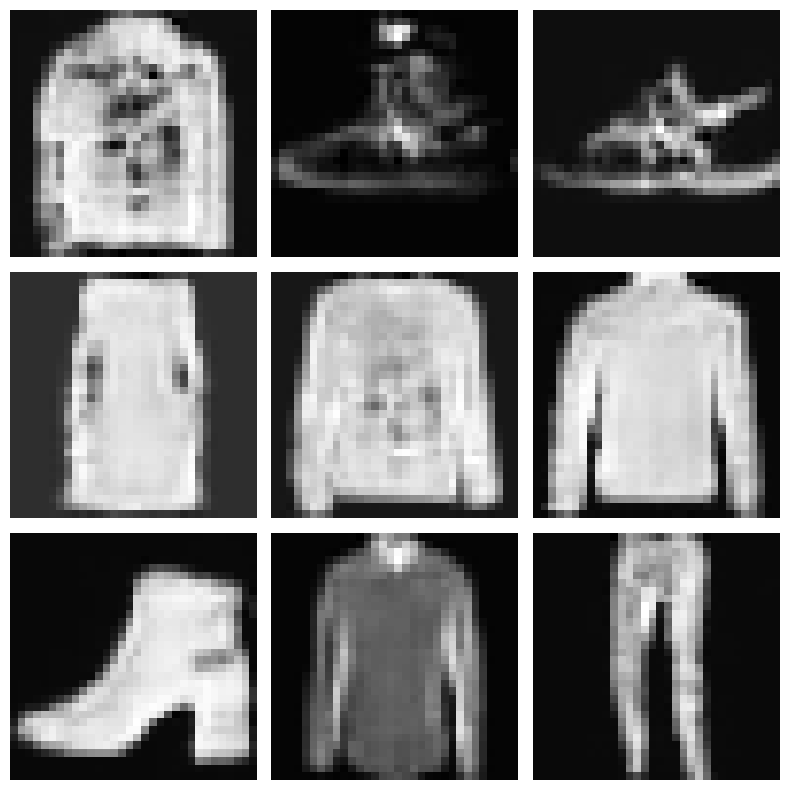

In [8]:
gen_input = torch.randn(9, latent_vector_size, 1, 1, device=torch_device)
generator.eval()
gen_output = generator(gen_input)
show_nine(gen_output)